In [2]:
import numpy as np
import scipy.interpolate as spi
from scipy.stats import norm
from scipy.interpolate import CubicSpline
from scipy.interpolate import Akima1DInterpolator



In [3]:
# --- Function to calculate hybrid CDF and PDF ---
def compute_cdf_pdf_interpolators(quantiles, probabilities, y_min=-30, y_max=30):
    """
    Returns interpolation functions for CDF and PDF using linear, PCHIP, and hybrid methods.

    Parameters:
    - quantiles: Array of quantiles.
    - probabilities: Array of associated probabilities for the quantiles.
    - y_min: Minimum x value for extrapolation.
    - y_max: Maximum x value for extrapolation.

    Returns:
    - cdf_linear(x): Linear interpolation CDF function.
    - cdf_pchip(x): PCHIP interpolation CDF function.
    - hybrid_cdf(x): Hybrid CDF (PCHIP + normal tails).
    - pdf_linear(x): Linear interpolation PDF function.
    - pdf_pchip(x): PCHIP derivative PDF function.
    - pdf_hybrid(x): Hybrid PDF (PCHIP + normal tails).
    """

    # Extend quantile and probability arrays
    full_quantiles = np.concatenate(([y_min], quantiles, [y_max]))
    full_probabilities = np.concatenate(([0], probabilities, [1]))

    # --- Calculate minimum difference between consecutive quantiles ---
    delta_quantiles = np.diff(quantiles)
    min_delta_quantile = np.min(delta_quantiles)


    # --- Fit Normal Distributions for Tails ---
    def fit_tail_distribution(quantiles, probabilities):
        """Fits a normal distribution to the given quantiles and associated probabilities."""
        z_scores = norm.ppf(probabilities)
        sigma = (quantiles[1] - quantiles[0]) / (z_scores[1] - z_scores[0])
        mu = quantiles[0] - sigma * z_scores[0]
        return mu, sigma

    # Fit left and right tails
    mu_left, sigma_left = fit_tail_distribution(quantiles[:2], probabilities[:2])
    mu_right, sigma_right = fit_tail_distribution(quantiles[-2:], probabilities[-2:])

    # --- Define CDF Interpolators ---
    cdf_linear_interpolator = spi.interp1d(
        full_quantiles, full_probabilities, kind="linear", fill_value=(0, 1), bounds_error=False
    )
    #cdf_pchip_interpolator = spi.PchipInterpolator(full_quantiles, full_probabilities, extrapolate=True)
    #cdf_pchip_interpolator = spi.interp1d(quantiles, probabilities, kind='quadratic', fill_value=(0, 1), bounds_error=False)
    cdf_pchip_interpolator = spi.Akima1DInterpolator(full_quantiles, full_probabilities)


    def cdf_linear(x):
        """Linear interpolation CDF function."""
        return float(np.clip(cdf_linear_interpolator(x), 0, 1))

    def cdf_pchip(x):
        """PCHIP interpolation CDF function."""
        return float(np.clip(cdf_pchip_interpolator(x), 0, 1))

    def hybrid_cdf(x):
        """
        Hybrid CDF:
        - Left normal fit for x < first quantile
        - PCHIP interpolation for middle range
        - Right normal fit for x > last quantile
        """
        if x < quantiles[0]:  # Left tail
            return norm.cdf(x, loc=mu_left, scale=sigma_left)
        elif x > quantiles[-1]:  # Right tail
            return norm.cdf(x, loc=mu_right, scale=sigma_right)
        else:  # Middle range (PCHIP interpolation)
            return float(np.clip(cdf_pchip_interpolator(x), 0, 1))

    # --- Define PDF functions (derivatives of CDFs) ---
    def pdf_linear(x):
        """Approximates PDF using finite differences of the linear CDF."""
        #eps = eps  # Small step for numerical differentiation
        eps = 0.01
        return (cdf_linear(x + eps) - cdf_linear(x - eps)) / (2 * eps)

    def pdf_linear2(x):
        """Approximates PDF using finite differences of the linear CDF."""
        #eps = eps  # Small step for numerical differentiation
        eps = min_delta_quantile/2
        return (cdf_linear(x + eps) - cdf_linear(x - eps)) / (2 * eps)
    
    def pdf_pchip(x):
        """Approximates PDF using finite differences on the cubic interpolation CDF."""
        eps = min_delta_quantile/2

        return (cdf_pchip_interpolator(x + eps) - cdf_pchip_interpolator(x - eps)) / (2 * eps)
        #return cdf_pchip_interpolator.derivative()(x)

    def pdf_hybrid(x):
        """
        Hybrid PDF:
        - Left normal distribution for x < first quantile
        - PCHIP interpolation derivative for middle range
        - Right normal distribution for x > last quantile
        """
        if x < quantiles[0]:  # Left tail
            return norm.pdf(x, loc=mu_left, scale=sigma_left)
        elif x > quantiles[-1]:  # Right tail
            return norm.pdf(x, loc=mu_right, scale=sigma_right)
        else:  # Middle range (PCHIP interpolation)
            return cdf_pchip_interpolator.derivative()(x)

    return cdf_linear, cdf_pchip, hybrid_cdf, pdf_linear, pdf_linear2, pdf_pchip, pdf_hybrid


In [4]:
from scipy.stats import norm
from scipy.optimize import curve_fit
import numpy as np

# Define a function that maps probabilities to normal quantiles
def normal_cdf_inverse(p, mu, sigma):
    return norm.ppf(p, loc=mu, scale=sigma)

def fit_normal_dist_to_quantiles(probabilities, quantiles):
    """ Fits a normal distribution to given quantiles and probabilities. """
    probabilities = np.asarray(probabilities)
    quantiles = np.asarray(quantiles)
    
    # Debugging: Print inputs
    print("Probabilities:", probabilities)
    print("Quantiles:", quantiles)
    
    # Ensure valid inputs
    if np.any(np.isnan(probabilities)) or np.any(np.isnan(quantiles)):
        raise ValueError("Input contains NaN values!")
    
    if np.any(np.isinf(probabilities)) or np.any(np.isinf(quantiles)):
        raise ValueError("Input contains Inf values!")

    # Check if probabilities are within (0,1)
    if np.any(probabilities <= 0) or np.any(probabilities >= 1):
        raise ValueError("Probabilities must be between 0 and 1 (exclusive).")

    # Provide a reasonable initial guess
    mu_init = np.mean(quantiles)
    sigma_init = (np.max(quantiles) - np.min(quantiles)) / 4  # Rough estimate

    try:
        params, _ = curve_fit(normal_cdf_inverse, probabilities, quantiles, p0=[mu_init, sigma_init])
    except RuntimeError as e:
        print("Curve fitting failed:", e)
        return None, None

    mu_fit, sigma_fit = params
    print(f"Estimated Mean: {mu_fit}, Estimated Std Dev: {sigma_fit}")
    
    return mu_fit, sigma_fit

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_cdf_pdf(quantiles, probabilities, y_min, y_max, log_scale=True, eps=0.01, tail=False):
    """Plots the CDF and PDF for linear, Akima1DInterpolator, and hybrid interpolation methods."""

    # Generate x values for plotting
    x_values = np.linspace(y_min - 1, y_max + 1, 200)

    # Get CDF and PDF functions
    cdf_linear, cdf_pchip, hybrid_cdf, pdf_linear, pdf_linear2, pdf_pchip, pdf_hybrid = compute_cdf_pdf_interpolators(
        quantiles, probabilities, y_min, y_max
    )

    y_min_shift = 1
    cdf_linear_m, cdf_pchip_m, hybrid_cdf_m, pdf_linear_m, pdf_linear2_m, pdf_pchip_m, pdf_hybrid_m = compute_cdf_pdf_interpolators(
    quantiles, probabilities, y_min - y_min_shift, y_max + y_min_shift
)

    # Vectorized evaluation of CDFs and PDFs
    cdf_values_linear = np.array([cdf_linear(x) for x in x_values])
    cdf_values_pchip = np.array([cdf_pchip(x) for x in x_values])
    cdf_values_hybrid = np.array([hybrid_cdf(x) for x in x_values])
    cdf_values_linear_m = np.array([cdf_linear_m(x) for x in x_values])


    pdf_values_linear = np.array([pdf_linear(x) for x in x_values])
    pdf_values_linear2 = np.array([pdf_linear2(x) for x in x_values])

    pdf_values_linear_m = np.array([pdf_linear_m(x) for x in x_values])

    pdf_values_pchip = np.array([pdf_pchip(x) for x in x_values])
    pdf_values_hybrid = np.array([pdf_hybrid(x) for x in x_values])


    

    # --- Plot CDFs ---
    plt.figure(figsize=(11, 6))
    plt.plot(x_values, cdf_values_linear, label=f"Linear Interpolation, y_min={y_min}", color='b', linewidth=1.5)
    plt.plot(x_values, cdf_values_linear_m, label=f"Linear Interpolation, y_min={y_min + y_min_shift}", color='m', linewidth=1.5)

    plt.plot(x_values, cdf_values_pchip, label="Akima Spline Interpolation", color='r', linewidth=1.5)
    plt.plot(x_values, cdf_values_hybrid, label="Akima Spline + Normal Tails Interpolation", color='g', linewidth=1.5)
    plt.plot(x_values, norm.cdf(x_values), label="true cdf", linestyle='--')
    plt.scatter(quantiles, probabilities, color='y', marker='o', label="Quantiles")
    
    plt.xlabel("Value")
    plt.ylabel("Cumulative Probability")
    plt.title("CDF Estimation of N(0,1) via 9 quantiles with different interpolation methods")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.xlim(x_values[0], x_values[-1])
    #plt.xlim(-1.4, 1.4)

    #plt.ylim(-0.1, 0.1)


    plt.show()

    mu, sigma = fit_normal_dist_to_quantiles(probabilities, quantiles)

    # --- Plot PDFs ---
    plt.figure(figsize=(11, 6))

    if tail:
        plt.plot(x_values, pdf_values_linear, label=f"Linear Interpolation epsilon=0.01, y_min={y_min}", color='#008000', linewidth=1.5, linestyle='--')
        plt.plot(x_values, pdf_values_linear_m, label=f"Linear Interpolation epsilon=0.01, y_min={y_min + y_min_shift}", color='r', linestyle='--', linewidth=1)
    
    else:
        plt.plot(x_values, pdf_values_linear, label="Linear Interpolation epsilon=0.01", color='#008000', linewidth=1.5, linestyle='--')
        plt.plot(x_values, pdf_values_linear2, label="Linear Interpolation epsilon=min_delta_quantile/2", color='r', linestyle='--', linewidth=1)

    plt.plot(x_values, pdf_values_pchip, label="Akima Spline Interpolation", color='b', linestyle="-", linewidth=1.5)
    plt.plot(x_values, pdf_values_hybrid, label="Akima Spline + Normal Tails Interpolation", color='r', linestyle="-", linewidth=1.5)
    #plt.plot(x_values, norm.pdf(x_values), label="true pdf", color='g', linewidth=1.1, linestyle='--')
    plt.plot(x_values, norm.pdf(x_values, loc=mu, scale=sigma), label="true pdf", color='g', linewidth=1.1, linestyle='--')

    # Evaluate PDFs at quantile points
    #pdf_at_quantiles_linear = np.array([pdf_linear(q) for q in quantiles])
    pdf_at_quantiles_pchip = np.array([pdf_pchip(q) for q in quantiles])
    pdf_at_quantiles_hybrid = np.array([pdf_hybrid(q) for q in quantiles])
    #pdf_at_quantiles_linear2 = np.array([pdf_linear2(q) for q in quantiles])


    # Scatter plot for PDFs at quantiles
    #plt.scatter(quantiles, pdf_at_quantiles_linear, color='#008000', marker='o', s=20, label="Linear PDF at Quantiles")
    #plt.scatter(quantiles, pdf_at_quantiles_pchip, color='b', marker='v', s=20, label="Akima Spline PDF at Quantiles")
    #plt.scatter(quantiles, pdf_at_quantiles_pchip, color='r', marker='v', s=20, label="Akima Spline PDF at Quantiles")
    plt.scatter(quantiles, pdf_at_quantiles_hybrid, color='r', marker='x', s=20, label="Akima Spline + Normal Tails PDF at Quantiles")

    #plt.ylim(0.1, 0.4)

    plt.xlabel("Value")
    plt.title("PDF Estimation of N(0,1) via 9 quantiles with different interpolation methods")
    plt.legend(loc="upper left", fontsize=12, bbox_to_anchor=(1.15, 1.0))
    plt.grid(True)
    plt.xlim(x_values[0], x_values[-1])
    #plt.xlim(-5, 5)

    #plt.xlim(-6, 6)
    #plt.xlim(-1.4, 1.4)
    #plt.ylim(0.1, 0.45)


    if log_scale:
        plt.yscale("log")
        plt.ylim(1e-3, 1)
        plt.ylabel("Probability Density (log scale)")
    else:
        plt.ylabel("Probability Density")

    plt.show()


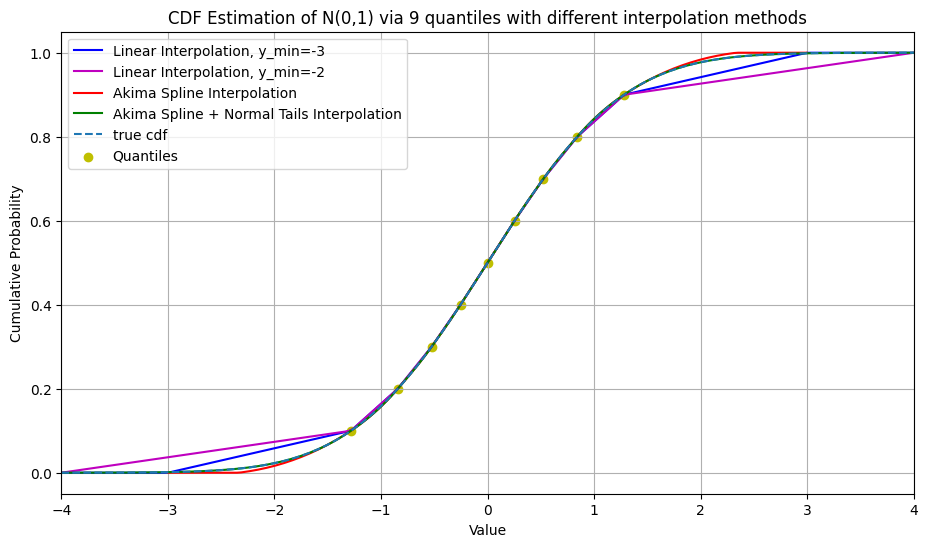

Probabilities: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
Quantiles: [-1.28155157 -0.84162123 -0.52440051 -0.2533471   0.          0.2533471
  0.52440051  0.84162123  1.28155157]
Estimated Mean: -3.0819390988122016e-33, Estimated Std Dev: 1.0


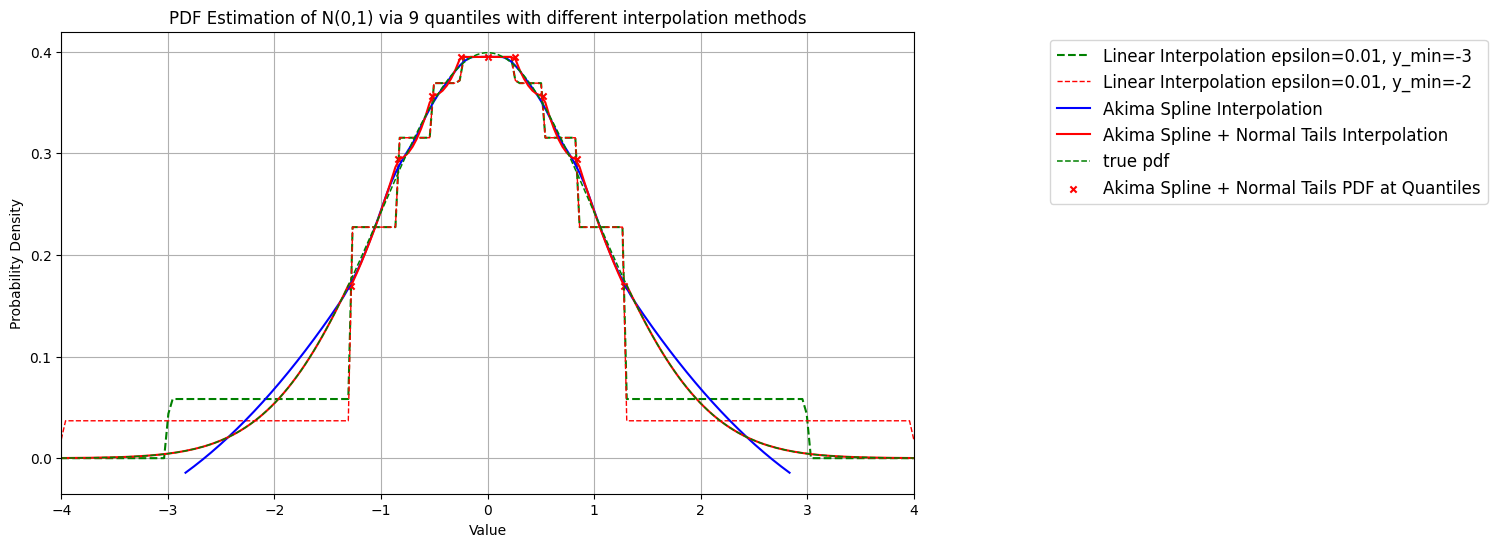

In [10]:
#quantiles = np.array([-2.326, -1.960, -1.645, -1.282, 0, 1.282, 1.645, 1.960,2.326])
#probabilities = np.array([0.02, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 0.98])


probabilities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
quantiles = norm.ppf(probabilities)

plot_cdf_pdf(quantiles, probabilities, y_min=-3, y_max=3, log_scale=False, tail=True)


In [ ]:
def log_likelihood(y, pdf_function):
    """
    Computes the log-likelihood for a given y value evaluated at a pdf function.
    
    Parameters:
    - y: observed true values.
    - pdf_function: A function that computes the PDF.
    
    Returns:
    - The total negative log-likelihood.
    """
    pdf_value = pdf_function(y)
    log_pdf = np.log(pdf_value)
    
    return log_pdf


# Test printout for selected value

In [130]:
# Example inputs
quantiles = np.array([-2.326, -1.960, -1.645, -1.282, 0, 1.282, 1.645, 1.960,2.326])
probabilities = np.array([0.02, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 0.98])

# Get all CDF and PDF functions
cdf_linear, cdf_pchip, hybrid_cdf, pdf_linear, pdf_linear2, pdf_pchip, pdf_hybrid = compute_cdf_pdf_interpolators(quantiles, probabilities)

# Choose an x value
x_value = 1.5

# Compute CDF values
print("Linear CDF at x =", x_value, ":", cdf_linear(x_value))
print("PCHIP CDF at x =", x_value, ":", cdf_pchip(x_value))
print("Hybrid CDF at x =", x_value, ":", hybrid_cdf(x_value))

# Compute PDF values
print("Linear PDF at x =", x_value, ":", pdf_linear(x_value))
print("PCHIP PDF at x =", x_value, ":", pdf_pchip(x_value))
print("Hybrid PDF at x =", x_value, ":", pdf_hybrid(x_value))



Linear CDF at x = 1.5 : 0.8600550964187328
PCHIP CDF at x = 1.5 : 0.860754147141796
Hybrid CDF at x = 1.5 : 0.860754147141796
Linear PDF at x = 1.5 : 0.27548209366391463
PCHIP PDF at x = 1.5 : 0.27813056930996277
Hybrid PDF at x = 1.5 : 0.293640606905417


# Test with quantiles given back by TabPFN

In [172]:
quantiles_2 = np.array([-3.302027, -2.657532, -2.326192, -2.163070, -1.983908, -1.761671, -1.496187, -1.286693, -1.028827])
quantiles_3 = np.array([-3.295995, -2.666942, -2.325560, -2.164748, -1.986944, -1.763564, -1.498355, -1.278293, -1.031841])
quantiles_4 = np.array([-3.289948, -2.672929, -2.321413, -2.163413, -1.990395, -1.773206, -1.510069, -1.285333, -1.042485])
probabilities = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

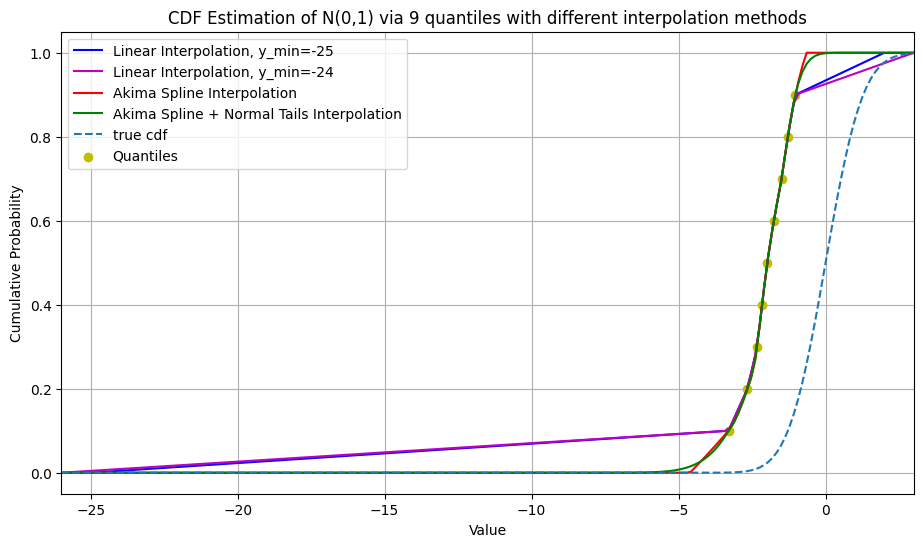

Probabilities: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
Quantiles: [-3.302027 -2.657532 -2.326192 -2.16307  -1.983908 -1.761671 -1.496187
 -1.286693 -1.028827]
Estimated Mean: -2.0006785555555555, Estimated Std Dev: 0.8557809650959824


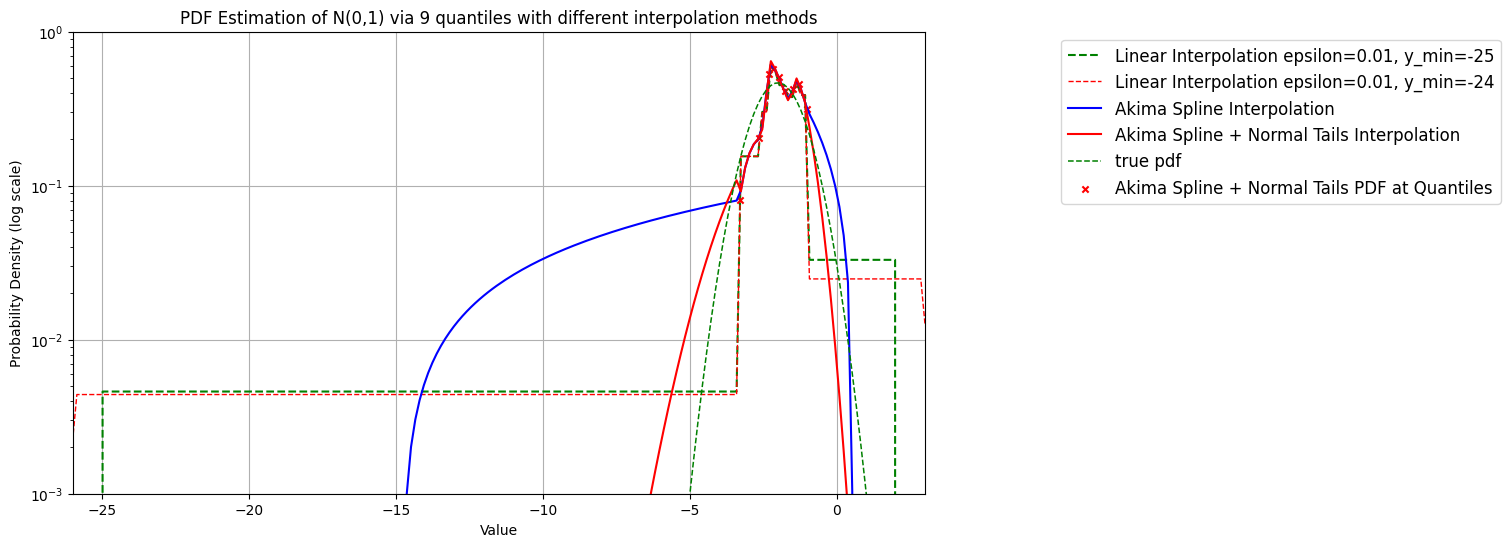

In [174]:
plot_cdf_pdf(quantiles_2, probabilities, -25, 2, log_scale=True, tail=True)

In [161]:
from scipy.optimize import curve_fit

# Define a function that maps probabilities to normal quantiles
def normal_cdf_inverse(p, mu, sigma):
    return norm.ppf(p, loc=mu, scale=sigma)

# Fit the normal distribution
params, _ = curve_fit(normal_cdf_inverse, probabilities, quantiles_2, p0=[0, 1])  # Initial guess: mean=0, std=1

mu_fit, sigma_fit = params
print(f"Estimated Mean: {mu_fit}, Estimated Std Dev: {sigma_fit}")

Estimated Mean: -2.0006785552168824, Estimated Std Dev: 0.8557809665149574
